# Notebook to Retrieve Data from the IBGE SIDRA API
---
This notebook offers a user-friendly interface for accessing data from the Brazilian Institute of Geography and Statistics (IBGE) API, emphasizing data tracking and reproducibility.

### Logging and Tracking
- **Detailed Command Logging**:  
  - **Info-Level Logging in the Notebook**: During the notebook session, commands are logged at the info level, meaning important events and steps are recorded to help users understand what actions have been taken.  
  - **Debug-Level Logging to a File**: A separate log file captures more granular, debug-level details. This enables deeper troubleshooting if issues arise, while keeping the notebook interface focused on higher-level information.  
  - **Unique Session Logs**: For each notebook session, a new log file is generated and identified with a unique ID. This ensures that logs from one session don’t overwrite another, making it easier to track actions and resolve issues in the future.

- **File Traceability via Hashing**:  
  - Each file created by the notebook is assigned a unique identifier.  
  - The file’s hash is computed and stored in the log file. This provides a reliable way to verify file integrity and maintain a clear link between the file and its corresponding session, allowing users to trace the origins of data and detect any changes over time.

 Note that IBGE has several APIS (https://servicodados.ibge.gov.br/api/docs). Two of them have the agregate data we are interested in:
 - Agregados: https://servicodados.ibge.gov.br/api/docs/agregados?versao=3
 - Sidra API: https://apisidra.ibge.gov.br/


## Notebook Setup and Dependencies Loading
---

Run the cell below in order to load dependencies, metadata, and start the logging session.

In [1]:
# Importing external libraries and functions
import os
import sys
import hashlib
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
from datetime import datetime

# Add the 'src' folder to the Python path so project-specific modules can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# Import project-specific functions
from logger import start_logger
from ibge import load_ibge_series_metadata, name_to_details, build_URL, fetch_and_save
from ui import raw_cleanup_widget

# Enable automatic reloading of modules when their source code changes
%reload_ext autoreload
%autoreload 2

# Define Session ID
session_type = "IBGE"
session_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

# Setup Logging
log_file_name = f"../logs/{session_type}_{session_ID}.log"
logger_name = "root"
logger = start_logger(logger_name, log_file_name)

raw_cleanup_widget()


2025-04-04 10:14:43,552 - INFO - Logger started. File path: ../logs/IBGE_20250404_101443.log


## Select Date Range and Series for IBGE SIDRA API Query
---

To include additional series in the list, update the IBGE metadata JSON file.  

Refer to the log file for the metadata file name and location. The file can be edited manually using any text editor.

After making changes, **re-run the cell above** to reload the updated metadata into the notebook.

In [2]:
# Load IBGE series metadata
df_ibge_series_metadata = load_ibge_series_metadata()

# --- API Selection ---
api_label = widgets.HTML("<b>Select API:</b>")
api_dropdown = widgets.Dropdown(
    options=["Agregados", "SIDRA"],
    value="SIDRA",
    layout=widgets.Layout(width='250px')
)

# This will reflect the dropdown value as a boolean
def get_sidra_status():
    return api_dropdown.value == "SIDRA"

# --- Frequency selection ---
frequency_label = widgets.HTML("<b>Choose frequency:</b>")
frequency_dropdown = widgets.Dropdown(
    options=["quarterly", "annual", "monthly"],
    value="quarterly",
    layout=widgets.Layout(width='250px')
)

# --- Series selection ---
series_label = widgets.HTML("<b>Select series:</b> (hold CTRL or CMD to select multiple)")
series_selector = widgets.SelectMultiple(
    options=[],  # to be filled dynamically
    layout=widgets.Layout(width='500px', height='200px')
)

# Update series options when frequency changes
def update_series_options(change):
    selected_freq = change["new"]
    filtered_index = df_ibge_series_metadata[df_ibge_series_metadata["frequency"] == selected_freq].index
    series_selector.options = list(filtered_index)

# Initialize and attach observer
update_series_options({"new": frequency_dropdown.value})
frequency_dropdown.observe(update_series_options, names="value")

# Display full widget interface
display(
    widgets.VBox([
        api_label,
        api_dropdown,
        frequency_label,
        frequency_dropdown,
        series_label,
        series_selector,
    ])
)

2025-04-04 10:14:46,056 - INFO - Loaded IBGE Metadata from file: ../data/metadata/ibge_series.json


2025-04-01 20:08:30,584 - INFO - Requesting data for: GDP Quarterly - Real (Seasonally Adjusted) 1621-584-90707
2025-04-01 20:08:34,077 - INFO - JSON file saved: ../data/raw/IBGE_20250401_200720_T1621-V584_200830.json
2025-04-01 20:08:34,082 - INFO - CSV file saved: ../data/raw/IBGE_20250401_200720_T1621-V584_200830.csv


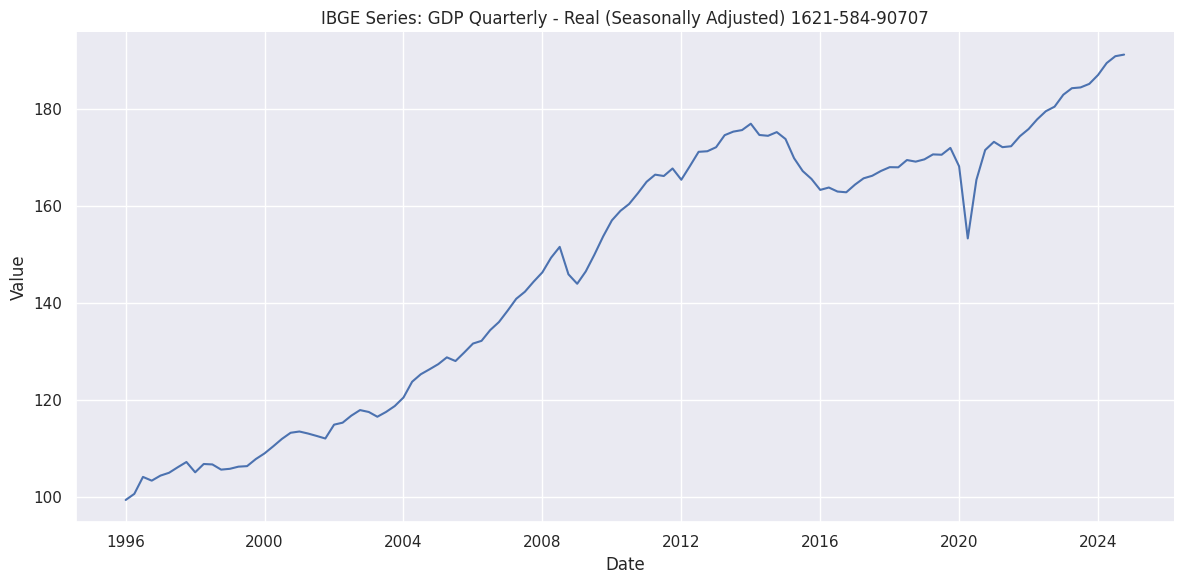

In [3]:
# Store selected series in a variable
selected_series_names = list(series_selector.value)

# Get API choice boolean:
sidra = get_sidra_status()

# Save Selected Series
for name in selected_series_names:

    #Select table variable and category from series name
    table,variable,category, geography, frequency = name_to_details(name,df_ibge_series_metadata,sidra)

    #Build URL
    url = build_URL(table,variable,category, geography,sidra)

    #Define Basefilename
    timestamp = datetime.now().strftime("%H%M%S")
    base_filename = f"../data/raw/{session_type}_{session_ID}_T{table}-V{variable}_{timestamp}"

    #Fetch data and save JSON and CSV files
    df = fetch_and_save(url, name, base_filename,frequency)

    if isinstance(df, pd.DataFrame):
        # Plot data
        ## Use notebook-friendly Seaborn style
        sns.set_theme()
        sns.set_context("notebook")

        ## Create the plot
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df, x="data", y="valor")

        ## Add labels and title
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title(f"IBGE Series: {name}")

        ## Clean up borders
        sns.despine()

        ## Display
        plt.tight_layout()
        plt.show()
